In [3]:
# import dependencies
import pandas as pd
from selenium import webdriver
from zipfile import ZipFile
import urllib.request
import os
import time

## Get zip file links

In [5]:
# since we can't use requests to get links from the html,
# we must use chromedriver to emulate visiting the page
browser = webdriver.Chrome()
browser.get('https://s3.amazonaws.com/tripdata/index.html')

# wait for browser to load
time.sleep(5)

# get all the anchors in the page
anchors = browser.find_elements_by_tag_name('a')

# create list of all the links
links_all = [link.get_attribute('href') for link in anchors]

# create list of 2019 NYC links
links_2019 = [link for link in links_all if '2019' in link]

# preview links
links_2019

['https://s3.amazonaws.com/tripdata/201901-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201902-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201903-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201904-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201905-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201907-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201910-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201911-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/201912-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201901-citibike-tripdata.csv.zip',
 'https://s3.amazonaws.com/tripdata/JC-201902-citibike-tripdata.csv.zip',


## Create Dataframe containing 2019 data for Jersey City and NYC

In [6]:
# function for creating dataframe for each link
def create_df(link):
    
    # create local zip file
    url = urllib.request.urlopen(link)
    open('temp.zip', 'wb').write(url.read())
        
    # read with zipfile, select the csv, create dataframe from csv
    with ZipFile('temp.zip') as myzip:
        with myzip.open(link.split('/')[4].split('.z')[0]) as myfile:
            df = pd.read_csv(myfile)
        
    # rename columns
    df.columns = ['Trip Duration', 
                  'Start Time', 
                  'Stop Time', 
                  'Start Station ID', 
                  'Start Station Name', 
                  'Start Station Latitude', 
                  'Start Station Longitude', 
                  'End Station ID', 
                  'End Station Name', 
                  'End Station Latitude', 
                  'End Station Longitude', 
                  'Bike ID', 
                  'User Type', 
                  'Birth Year', 
                  'Gender']
    
    # print link for confirmation
    print(link)
    
    # remove temperary file
    os.remove('temp.zip')
    
    return df

In [7]:
# create dataframe containing all the 2019 NYC links
df_2019 = pd.DataFrame()
for link in links_2019:
    df = create_df(link)
    df_2019 = df_2019.append(df, ignore_index=True, sort=False)

https://s3.amazonaws.com/tripdata/201901-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201902-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201903-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201904-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201905-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201907-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201908-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201909-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201910-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201911-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/201912-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201901-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201902-citibike-tripdata.csv.zip
https://s3.amazonaws.com/tripdata/JC-201903-citibike-tri

In [8]:
# preview created dataframe
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20956644 entries, 0 to 20956643
Data columns (total 15 columns):
Trip Duration              int64
Start Time                 object
Stop Time                  object
Start Station ID           float64
Start Station Name         object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID             float64
End Station Name           object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                    int64
User Type                  object
Birth Year                 int64
Gender                     int64
dtypes: float64(6), int64(4), object(5)
memory usage: 2.3+ GB


## Cleaning

In [12]:
# make a copy for cleaning
df_2019_copy = df_2019.copy()

# convert start/stop times to datetime
df_2019_copy['Start Time'] = pd.to_datetime(df_2019_copy['Start Time'])
df_2019_copy['Stop Time'] = pd.to_datetime(df_2019_copy['Stop Time'])

# add age column
df_2019_copy['Age'] = pd.to_numeric(2019 - df_2019_copy['Birth Year'])

# remove trips with riders older than 100
df_2019_copy = df_2019_copy[df_2019_copy['Age'] < 100]

# remove gender values greater than 2
df_2019_copy = df_2019_copy[df_2019_copy['Gender'] < 3]

# remove trips with a duration longer than 24 hours
df_2019_copy['Trip Duration'] = df_2019_copy[df_2019_copy['Trip Duration'] < 86400]
df_2019_copy['Trip Duration'] = pd.to_numeric(df_2019_copy['Trip Duration'])

# drop NAs
df_2019_copy = df_2019_copy.dropna(how='any').reset_index(drop=True)

# drop random rows so that the Tableau public max row requirement of 15m is met
df_2019_copy.drop(df_2019_copy.sample(20940031-15000000).index, inplace=True)
df_2019_copy = df_2019_copy.reset_index()

display(df_2019_copy.describe())
display(df_2019_copy.info())
display(df_2019_copy)

,index,Trip Duration,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,Bike ID,Birth Year,Gender,Age
count,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07
mean,1.046981e+07,8.546023e+02,1.694981e+03,4.073706e+01,-7.398321e+01,1.686042e+03,4.073675e+01,-7.398342e+01,2.966304e+04,1.980266e+03,1.164660e+00,3.873369e+01
std,6.044858e+06,1.373190e+03,1.480308e+03,3.020041e-02,2.149542e-02,1.480014e+03,3.005057e-02,2.153017e-02,7.489040e+03,1.196358e+01,5.372197e-01,1.196358e+01
min,0.000000e+00,6.100000e+01,7.200000e+01,4.065540e+01,-7.408364e+01,7.200000e+01,4.065540e+01,-7.408364e+01,1.452900e+04,1.920000e+03,0.000000e+00,1.600000e+01
25%,5.235254e+06,3.580000e+02,3.850000e+02,4.071755e+01,-7.399601e+01,3.820000e+02,4.071755e+01,-7.399662e+01,2.548600e+04,1.970000e+03,1.000000e+00,2.900000e+01
50%,1.046989e+07,6.080000e+02,5.170000e+02,4.073705e+01,-7.398584e+01,5.160000e+02,4.073653e+01,-7.398632e+01,3.077200e+04,1.983000e+03,1.000000e+00,3.600000e+01
75%,1.570487e+07,1.070000e+03,3.294000e+03,4.075715e+01,-7.397188e+01,3.294000e+03,4.075660e+01,-7.397208e+01,3.501100e+04,1.990000e+03,1.000000e+00,4.900000e+01
max,2.094003e+07,8.637300e+04,3.911000e+03,4.081830e+01,-7.389795e+01,3.911000e+03,4.081830e+01,-7.389795e+01,4.208800e+04,2.003000e+03,2.000000e+00,9.900000e+01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000000 entries, 0 to 14999999
Data columns (total 17 columns):
index                      int64
Trip Duration              float64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID           float64
Start Station Name         object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID             float64
End Station Name           object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                    int64
User Type                  object
Birth Year                 int64
Gender                     int64
Age                        int64
dtypes: datetime64[ns](2), float64(7), int64(5), object(3)
memory usage: 1.9+ GB


None

,index,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Age
0,0,320.0,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160.0,Central Park West & W 76 St,40.778968,-73.973747,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416,15839,Subscriber,1971,1,48
1,1,316.0,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519.0,Pershing Square North,40.751873,-73.977706,518.0,E 39 St & 2 Ave,40.747804,-73.973442,32723,Subscriber,1964,1,55
2,5,535.0,2019-01-01 00:08:33.179,2019-01-01 00:17:28.354,3630.0,Frederick Douglass Blvd & W 115 St,40.803865,-73.955931,3529.0,Lenox Ave & W 130 St,40.810792,-73.943068,30315,Subscriber,1989,2,30
3,6,280.0,2019-01-01 00:09:21.006,2019-01-01 00:14:01.151,3675.0,3 Ave & E 95 St,40.784597,-73.949685,3288.0,E 88 St & 1 Ave,40.778301,-73.948813,35391,Subscriber,1987,1,32
4,7,1547.0,2019-01-01 00:11:22.907,2019-01-01 00:37:10.055,285.0,Broadway & E 14 St,40.734546,-73.990741,3358.0,Garfield Pl & 8 Ave,40.671198,-73.974841,35551,Subscriber,1981,1,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14999995,20940025,5008.0,2019-12-31 22:58:52.887,2020-01-01 00:22:21.107,3792.0,Columbus Dr at Exchange Pl,40.716870,-74.032810,3268.0,Lafayette Park,40.713464,-74.062859,29280,Customer,1969,0,50
14999996,20940026,283.0,2019-12-31 23:12:18.548,2019-12-31 23:17:01.874,3195.0,Sip Ave,40.730897,-74.063913,3679.0,Bergen Ave,40.722104,-74.071455,29245,Customer,1990,1,29
14999997,20940027,267.0,2019-12-31 23:19:03.584,2019-12-31 23:23:30.664,3186.0,Grove St PATH,40.719586,-74.043117,3205.0,JC Medical Center,40.716540,-74.049638,26153,Subscriber,1989,1,30
14999998,20940028,379.0,2019-12-31 23:19:06.583,2019-12-31 23:25:25.797,3209.0,Brunswick St,40.724176,-74.050656,3185.0,City Hall,40.717733,-74.043845,26276,Subscriber,1984,1,35


## Quick scan for correlations

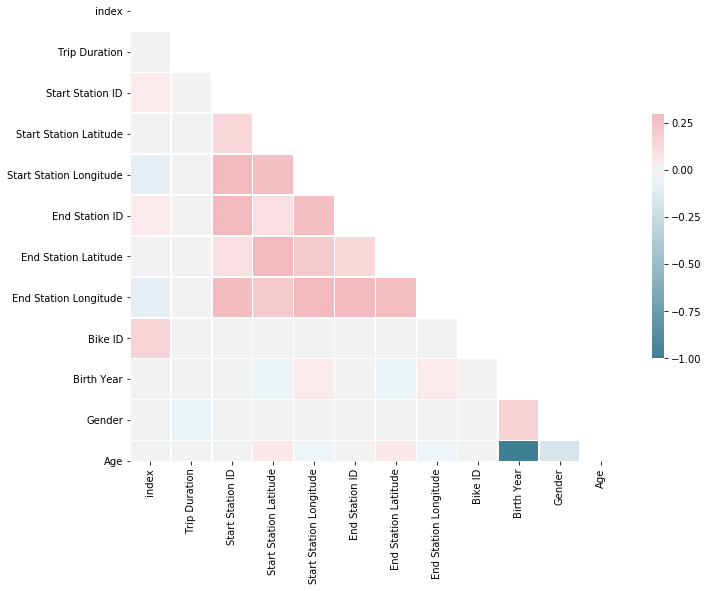

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_2019_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Export

In [15]:
df_2019_copy.to_csv('2019.csv', encoding='utf-8', index=False)

In [16]:
df_2019_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000000 entries, 0 to 14999999
Data columns (total 17 columns):
index                      int64
Trip Duration              float64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID           float64
Start Station Name         object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID             float64
End Station Name           object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                    int64
User Type                  object
Birth Year                 int64
Gender                     int64
Age                        int64
dtypes: datetime64[ns](2), float64(7), int64(5), object(3)
memory usage: 1.9+ GB
